In [ ]:
!pip install --quiet cornac==1.12.0

     |████████████████████████████████| 13.4 MB 5.4 MB/s 


In [ ]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd; pd.set_option("max_colwidth", 0);
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import cornac
from cornac.utils import cache
from cornac.datasets import filmtrust, amazon_clothing, movielens
from cornac.eval_methods import RatioSplit
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR, VMF
from cornac.data import GraphModality, TextModality, ImageModality
from cornac.data.text import BaseTokenizer

%tensorflow_version 1.x
import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = True

TensorFlow 1.x selected.
System version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Cornac version: 1.12.0
Tensorflow version: 1.15.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load data

In [ ]:
review = pd.read_csv('/content/drive/MyDrive/CS608/yelp/final_review_pa.csv')
review

review_id                 user_id  \
0       KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA   
1       8JFGBuHMoiNDyfcxuWNtrA  smOvOajNG0lS4Pq7d8g4JQ   
2       Xs8Z8lmKkosqW5mw_sVAoA  IQsF3Rc6IgCzjVV9DE8KXg   
3       J-4NdnDZ0pUQaUEEwDI9KQ  vrKkXsozqqecF3CW4cGaVQ   
4       G_5UczbCBJriUAbxz3J7Tw  clWLI5OZP2ad25ugMVI8gg   
...                        ...                     ...   
588265  ZcEx4UEnTnR_TEPEqwkKjA  gkg9VqsxPCgpfYXO1dl8CA   
588266  rtt1Ymczj-1Lb26JMsY2lA  M1cMsRL4L7IUr9RILDywEQ   
588267  MVg4YUQeEhCA7Z7RsBJSVg  7-7A0Avj47slLGV7yBFc8w   
588268  nLjbVsETpqO17RbFcqskkA  am7-gkH_PDz598oTdYSD6A   
588269  KlHxcAifUF5zDKpJCBrRsw  7ziWZULyiZv2TesYNMFf4g   

                   business_id  stars  useful  funny  cool  \
0       XQfwVwDr-v0ZS3_CbbE5Xw  3.0    0       0      0      
1       RZtGWDLCAtuipwaZ-UfjmQ  4.0    0       0      0      
2       eFvzHawVJofxSnD7TgbZtg  5.0    0       0      0      
3       rjuWz_AD3WfXJc03AhIO_w  5.0    2       2      2      
4       x4XdNhp0Xn8lOivzc77J-g  5.0    0       0      0      
...                        ...  ...   ..      ..     ..      
588265  Ea663rIHyKXz2VP2DPH7Cg  4.0    3       0      0      
588266  vt_esoDw6HG5ClM12OPkMg  4.0    4       3      4      
588267  ytynqOUb3hjKeJfRj5Tshw  3.0    1       0      0      
588268  3gVSrS4kffGGZT8oXHsIcw  3.0    2       0      2      
588269  qQO7ErS_RAN4Vs1uX0L55Q  4.0    1       0      0      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          text  \
0       If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1       Good food--loved the gnocchi with marinara\nthe baked eggplant appetizer was very good too\n\nThe service was very slow, but despite this, I'd go back, the food is just that good                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
review['review_id'].groupby(review['user_id']).count().sort_values(ascending=False)

user_id
ovS01jAmR82MZsFnQWGAgA    100
frIiDayrnrLs0kZb3_kTAw    100
IOjwt-cRHwdenA63T_rt5w    100
nRpUQsLfGWBJ8u7gcj6qzA    100
rO9ojBDK8lw0x6QVoa4DbA    100
                         ... 
ZuR-G07B_86tzp7ffvHc1w    10 
FrP2Y6l_UmvC-8Q9OFn26g    10 
Fqo9By9ExjAhbdSIpTCJgA    10 
35jolIAJJIV4EXJltVDVNw    10 
Hkg4b2x8LlYbq2molIFdhw    10 
Name: review_id, Length: 26763, dtype: int64

In [ ]:
review[review['user_id'] == 'qfVtDWAVZQsJ6C-uo8HRDQ'].sort_values(by='stars', ascending=False)[:10]


review_id                 user_id  \
27916   mW6beNeFOrEkAqMItAogLA  qfVtDWAVZQsJ6C-uo8HRDQ   
191616  ikjNbrhp0eKANEisewEwZg  qfVtDWAVZQsJ6C-uo8HRDQ   
358072  P1zbbdJ2psvpcvI-WJBwyg  qfVtDWAVZQsJ6C-uo8HRDQ   
447607  WnnO1DvBrocB-9rrYMJKUg  qfVtDWAVZQsJ6C-uo8HRDQ   
327207  qU6AM1W7Pvp6-nenXVlYmQ  qfVtDWAVZQsJ6C-uo8HRDQ   
35664   rj_qfJw9EAhMNmyWzPzOnQ  qfVtDWAVZQsJ6C-uo8HRDQ   
196705  gjUY1w2mn8fA3MDNMuBcrw  qfVtDWAVZQsJ6C-uo8HRDQ   
175751  D1iGOAjE9UUAe9JrWzpArA  qfVtDWAVZQsJ6C-uo8HRDQ   
527204  phj2hk_2_5wBKgljNDOY7w  qfVtDWAVZQsJ6C-uo8HRDQ   
560855  fuUnQKece5wp1WPHYMYH_w  qfVtDWAVZQsJ6C-uo8HRDQ   

                   business_id  stars  useful  funny  cool  \
27916   7mpYTDb24SywNMRn3yeakQ  5.0    0       0      0      
191616  ktMvtPI3TBkTOpSf1sTXWw  5.0    1       0      0      
358072  hxh1ongobphqXq30V13ukg  5.0    0       0      0      
447607  6EugUPdSAO_hqissL-tsYg  5.0    1       0      2      
327207  LFyuwzv0CHgR44y0XSJbPA  5.0    0       0      0      
35664   4_W5pstoN1166TGjjPOrMg  5.0    0       0      0      
196705  8yGZhBwFFLtOVLY9Do8ohQ  5.0    0       0      0      
175751  d8X3YfaxDcPM_CGJB1t5rw  5.0    1       0      2      
527204  Y-woMivHkCk4W3tTl1ktTA  5.0    2       0      0      
560855  VTW1lze7qeAc0HykFT-3rw  5.0    2       0      0      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                text  \
27916   my husband and i have eaten here 3 times in the past 3 or 4 years.  we don't go out to eat in the city that much anymore, but we really need to get out here more often.  each time we have gone, we have loved our meals.  the service is great, too.  we really liked the side dish brussel sprouts-highly recommend everyone try them.  some other dishes we've had include the duck, crab cake, cheese board, chorizo sausage, shrimp and grits.  everything has been great! highly recommend you go here for dinner!                      
191616  Very good tacos and guacamole & chips. This place was recommended to me since I was looking for tacos nearby to the tattoo shop that I frequent. I had el pastor tacos- very tasty. Would love to try the other menu items when in fishtown again!                                                                                                                                                                                                                                                                                             
358072  this place is awesome.  my husband and friends went here after his band played a show one night around the corner at the kung fu necktie.  it didn't seem like there was many good places to get food late at night around this neighborhood, but this place was a great surprise!  excellent food and beer selection.  I had pineapple pork tacos and a blueberry beer.  great bar with great food! highly recommended!  one thing; it is a small place, so it might not be best for a group of people unless you don't mind being crowded.   
447607  My husband and I heard about Anthony's service through neighbors.  So glad we took our dog here for daycare. Excellent price and Anthony and Kathy really love dogs, and you can tell they are passionate about dog care. My young dog (about 1 1/2 years old, blue pit mix)was pooped when I picked her up! What a wonderful local business to support!                                                                                                                                                                                       
327207  ordered ste

In [ ]:
# application demo 
business[business.business_id.isin(review[review['user_id'] == 'qfVtDWAVZQsJ6C-uo8HRDQ'].sort_values(by='stars', ascending=False)[:10].business_id)][['name', 'city', 'categories']]

name          city  \
443     The Twisted Tail                       Philadelphia   
7386    Prohibition Taproom                    Philadelphia   
41123   Thai Fusion Kitchen                    Folsom         
53802   Renata's Kitchen                       Philadelphia   
58618   Heffe                                  Philadelphia   
81882   Leo's Steak Shop                       Folcroft       
95819   Bottle Bar East                        Philadelphia   
110032  Peace of Mind Pet Services by Anthony  Secane         
141605  House                                  Media          
147732  Little Basil                           Morton         

                                                                                                                                                     categories  
443     Event Planning & Services, Whiskey Bars, American (New), American (Traditional), Venues & Event Spaces, Bars, Nightlife, Restaurants                     
7386    American (Traditional), Bars, Nightlife, Restaurants, Beer Bar, Gastropubs, Breakfast & Brunch, Tapas/Small Plates                                       
41123   Restaurants, Thai, Asian Fusion                                                                                                                          
53802   Breakfast & Brunch, Caterers, Tapas/Small Plates, Event Planning & Services, Middle Eastern, Mediterranean, Restaurants, Greek                           
58618   Restaurants, Tex-Mex, Italian, Food Stands, Latin American, Mexican                                                                                      
81882   Sandwiches, Restaurants, Burgers                                                                                                                         
95819   Food, Bars, American (Traditional), Nightlife, Gastropubs, Barbeque, Breakfast & Brunch, Restaurants, Pubs, Sports Bars, Beer, Wine & Spirits, Beer Bar  
110032  Pets, Dog Walkers, Pet Services, Pet Sitting                                                                                                             
141605  American (New), Restaurants, American (Traditional), Sandwiches, Breakfast & Brunch                                                                      
147732  Restaurants, Asian Fusion

In [ ]:
# application demo 
business[business.business_id.isin(review[review['user_id'] == '99SX3ljaydEZ0OAKFyi2AA'].sort_values(by='stars', ascending=False)[:10].business_id)][['name', 'city', 'categories']]

name          city  \
10054   HipCityVeg             Philadelphia   
51063   Lolita                 Philadelphia   
82440   Tom's Dim Sum          Philadelphia   
86580   Dizengoff              Philadelphia   
90897   South Philly Barbacoa  Philadelphia   
101352  Pho 75                 Philadelphia   
110470  PrimoHoagies           Philadelphia   
115394  Res Ipsa Cafe          Philadelphia   
127502  Fond                   Philadelphia   
137999  Abe Fisher             Philadelphia   

                                                                                                                                                       categories  
10054   Burgers, Vegetarian, Restaurants, Vegan                                                                                                                    
51063   Restaurants, Mexican                                                                                                                                       
82440   Restaurants, Chinese, Shanghainese, Dim Sum                                                                                                                
86580   Beer, Wine & Spirits, Middle Eastern, Restaurants, Food                                                                                                    
90897   Barbeque, Coffee & Tea, Mexican, Cannabis Clinics, Event Planning & Services, Personal Chefs, Restaurants, Juice Bars & Smoothies, Food, Health & Medical  
101352  Restaurants, Asian Fusion, Vietnamese                                                                                                                      
110470  Sandwiches, Restaurants, Italian                                                                                                                           
115394  Restaurants, Coffee & Tea, Cafes, Food, Breakfast & Brunch, Italian                                                                                        
127502  American (New), Bars, Seafood, Restaurants, Nightlife                                                                                                      
137999  Beer, Wine & Spirits, Nightlife, Food, Beer Bar, Bars, Restaurants, Modern European

In [ ]:
business = pd.read_csv('/content/drive/MyDrive/CS608/yelp/business.csv')
business

business_id                      name  \
0       Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1       mpf3x-BjTdTEA3yCZrAYPw  The UPS Store              
2       tUFrWirKiKi_TAnsVWINQQ  Target                     
3       MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries         
4       mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   
...                        ...                       ...   
150341  IUQopTMmYQG-qRtBk-8QnA  Binh's Nails               
150342  c8GjPIOTGVmIemT7j5_SyQ  Wild Birds Unlimited       
150343  _QAMST-NrQobXduilWEqSw  Claire's Boutique          
150344  mtGm22y5c2UHNXDFAjaPNw  Cyclery & Fitness Center   
150345  jV_XOycEzSlTx-65W906pg  Sic Ink                    

                                address           city state postal_code  \
0       1616 Chapala St, Ste 2           Santa Barbara  CA    93101        
1       87 Grasso Plaza Shopping Center  Affton         MO    63123        
2       5255 E Broadway Blvd             Tucson         AZ    85711        
3       935 Race St                      Philadelphia   PA    19107        
4       101 Walnut St                    Green Lane     PA    18054        
...               ...                           ...     ..      ...        
150341  3388 Gateway Blvd                Edmonton       AB    T6J 5H2      
150342  2813 Bransford Ave               Nashville      TN    37204        
150343  6020 E 82nd St, Ste 46           Indianapolis   IN    46250        
150344  2472 Troy Rd                     Edwardsville   IL    62025        
150345  238 Apollo Beach Blvd            Apollo beach   FL    33572        

         latitude   longitude  stars  review_count  is_open  \
0       34.426679 -119.711197  5.0    7             0         
1       38.551126 -90.335695   3.0    15            1         
2       32.223236 -110.880452  3.5    22            0         
3       39.955505 -75.155564   4.0    80            1         
4       40.338183 -75.471659   4.5    13            1         
...           ...        ...   ...    ..           ..         
150341  53.468419 -113.492054  3.0    13            1         
150342  36.115118 -86.766925   4.0    5             1         
150343  39.908707 -86.065088   3.5    8             1         
150344  38.782351 -89.950558   4.0    24            1         
150345  27.771002 -82.394910   4.5    9             1         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          attributes  \
0       {'ByAppointmentOnly': 'True'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1       {'BusinessAcceptsCreditCards': 'True'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2       {'BikeParking': 'True', 'BusinessAcceptsCreditCards': 'True'

In [ ]:
photo = pd.read_excel('/content/drive/MyDrive/CS608/yelp/photos.xlsx')
photo = photo.drop(columns = 'Unnamed: 4')
photo

photo_id             business_id  \
0       zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1       HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2       vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3       pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4       H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   
...                        ...                     ...   
199923  4Zia9NkAfQNjMfcIDhwJ-g  2HxkdqHmbYGj_BH1bLaiSw   
199924  KB96KRZRhRm8hUkI-OpGEA  _gVyuTRb_6HM-SNtqbpevQ   
199925  Klmojvaf2_2dP1XKzTsFmQ  NUyEOjfAl3HvkpzSpdwqeA   
199926  FNEiq7Mogec7t31OaU5juw  hE6YsHHV0fCz_UrGS4o6VA   
199927  NHEtLh7APk7Yssjo0h45VA  VIYvcX9SScnqmoI0so1KZA   

                                                    caption    label  
0       Nice rock artwork everywhere and craploads of taps.  inside   
1       NaN                                                  outside  
2       oyster shooter                                       drink    
3       Shrimp scampi                                        food     
4       NaN                                                  food     
...     ...                                                   ...     
199923  #Nektar                                              food     
199924  NaN                                                  inside   
199925  NaN                                                  food     
199926  Drinks by the water!                                 drink    
199927  NaN                                                  food     

[199928 rows x 4 columns]

In [ ]:
print(len(review['business_id'].unique())) #32223
print(len(review['user_id'].unique())) #26763

32223
26763


In [ ]:
# user and photo no relationship -> cannot use join
photo_dic = {}
for i in photo.index:
  if photo.loc[i]['business_id'] not in photo_dic and photo.loc[i]['business_id'] in review['business_id'].values:
    print(i)
    if photo.loc[i]['label'] == 'food': # food as the priority
      photo_dic[photo.loc[i]['business_id']] = photo.loc[i]['photo_id'] 
    elif photo.loc[i]['label'] == 'drink':
      photo_dic[photo.loc[i]['business_id']] = photo.loc[i]['photo_id']
    else:
      photo_dic[photo.loc[i]['business_id']] = photo.loc[i]['photo_id']
photo_dic

流式输出内容被截断，只能显示最后 5000 行内容。
25678
25698
25705
25716
25739
25797
25803
25830
25859
25862
25874
25875
25876
25884
25901
25949
25953
25970
25980
25987
26012
26022
26024
26083
26091
26092
26093
26097
26123
26137
26144
26163
26165
26167
26169
26201
26203
26205
26223
26233
26243
26266
26269
26271
26274
26277
26310
26313
26333
26340
26357
26385
26398
26401
26420
26421
26452
26458
26477
26485
26498
26510
26516
26517
26522
26528
26531
26534
26537
26538
26548
26550
26560
26568
26579
26590
26592
26601
26605
26635
26659
26666
26673
26679
26715
26725
26740
26753
26758
26764
26766
26809
26814
26820
26843
26850
26858
26881
26891
26906
26912
26914
26935
26954
26959
26975
26982
26984
26993
27021
27034
27055
27061
27063
27078
27092
27102
27106
27128
27141
27187
27196
27209
27214
27240
27246
27263
27273
27299
27305
27309
27321
27329
27341
27359
27368
27383
27386
27394
27397
27403
27413
27414
27417
27420
27430
27434
27465
27470
27487
27492
27499
27513
27524
27530
27546
27550
27563
27568
27574
27619
27636
2

{'BELS5YkYjDFkpbM2FuDdaA': 'Le9rMdT8YFlvqr431LctIQ',
 '3lW1gubDMpnEIlo45eUKhA': '50CbWRa6-tAKRPrq5mbABg',
 'jTFl9Cr7RqZqwjH-CI1ZPw': 'e0dD0np3hY3F8LoUtrNoPw',
 'tw_PmFjjCyg0t8Ek_kQz0Q': 'zNzVcwnSJ4kvjFnANIsIRg',
 'jkGQQ4_LgJx3hwPtCFkzbQ': 'J1rqVl8pAoMJtPfGA2HV9w',
 'WMkiheTT-8kRslImVLWMVw': '56xUu0i5oOBj9GdZqIg9_w',
 'd_UJWp4IlGS4sgnjE60eBw': '4vmoGjG2v42drfbEp0kGHw',
 'ML8LRwVVebZLQhV30p2ktQ': 'FYv4VGbG8j1qfBjGLcCnlQ',
 'M6ZoEY54OKKPq9O9Boee7g': 'J0rm3mI98dISWsbmQaZWjw',
 'BXVmIZlRe4n7v_WH8zzVjg': 'GW06J2b-0OaCL9ror-4TUA',
 'a6nLdjFGoy3XmWhdtqBR3w': 'KSTU-qgQk-xsv0WioJlzzw',
 'NRb2aT7MKQXAG2HhoU4JKQ': 'pu4LCGga1mc9eCEHN3CqQA',
 'VkMokNW-HLye5jc8_1l_vA': 'JyUo-KIUp3JJwHgS9FkLlA',
 'fmFiSeSGjaA8KI-xHB5Xxg': '651bNRdUW2f5_zv_3sJ-VQ',
 'AnxLo-wgSqSWePahtA3zEA': 'NMEE9D53FvWnr-rhpmAg9g',
 's-74t4aQKL2pWeQmIB-c1Q': 'DtsfhqhqUB-tjs5XbwJfXw',
 'mF8czpMukj36ovHb3lGSeg': '9Wkj-Vl5EYLS6OIy4EYigw',
 't6g6Lj8WzjIXXucCl9jdTQ': 'GZpflvLA8AvQ6zi8aerdHg',
 'jt1TfLJQN20aoVskD_8DuQ': 'Z0fXmxtTQ9PT2JFx8n

In [ ]:
#images that cannot open
# MduVueqYTBlEkX-axrh1ug.jpg 
# RLtBKD2rlfTaELWejmLBCA.jpg
# bf3ymV0YgP7B6rEoriaU2w.jpg
# ytJ4lihJrvyzMMRG-WwDNw.jpg
# 9RDbbAZB0HnL4hndCWB58w.jpg
# rrfwGSwt3eHxxypfu5PGTA.jpg
# YW1WMOkVbdFBrixDnKgoqA.jpg

nan_list = []
print(photo[photo['photo_id'] == 'MduVueqYTBlEkX-axrh1ug']['business_id'].values[0])
print(photo[photo['photo_id'] == 'RLtBKD2rlfTaELWejmLBCA']['business_id'].values[0])
print(photo[photo['photo_id'] == 'bf3ymV0YgP7B6rEoriaU2w']['business_id'].values[0])
print(photo[photo['photo_id'] == 'ytJ4lihJrvyzMMRG-WwDNw']['business_id'].values[0])
print(photo[photo['photo_id'] == '9RDbbAZB0HnL4hndCWB58w']['business_id'].values[0])
print(photo[photo['photo_id'] == 'rrfwGSwt3eHxxypfu5PGTA']['business_id'].values[0])
print(photo[photo['photo_id'] == 'YW1WMOkVbdFBrixDnKgoqA']['business_id'].values[0])

553Wn6JtUWDsxYFc29mnog
djn6PlsuFw_Z_gRA55QDcg
GUQtBJQPNixF5kwoJ1mKcQ
vpkCctZV4_q7iUkmtdZkzQ
of7Z4Q4gIQIb-ChC88gi1A
a1Bd6IhR_Bsthhff9VGLoA
qJKMyChtpyqPvf7HNfvq4A


In [ ]:
nan_count = 0
nan_list = ['553Wn6JtUWDsxYFc29mnog', 'djn6PlsuFw_Z_gRA55QDcg', 'GUQtBJQPNixF5kwoJ1mKcQ', 'vpkCctZV4_q7iUkmtdZkzQ', 'of7Z4Q4gIQIb-ChC88gi1A','a1Bd6IhR_Bsthhff9VGLoA', 'qJKMyChtpyqPvf7HNfvq4A']
for k, v in photo_dic.items():
  if isinstance(v, float):
    nan_list.append(k)
    nan_count += 1
print(nan_count)
nan_list

0


['553Wn6JtUWDsxYFc29mnog',
 'djn6PlsuFw_Z_gRA55QDcg',
 'GUQtBJQPNixF5kwoJ1mKcQ',
 'vpkCctZV4_q7iUkmtdZkzQ',
 'of7Z4Q4gIQIb-ChC88gi1A',
 'a1Bd6IhR_Bsthhff9VGLoA',
 'qJKMyChtpyqPvf7HNfvq4A']

In [ ]:
len(photo_dic)

7907

In [ ]:
review = review[review.business_id.isin(list(photo_dic.keys()))]

In [ ]:
with open(r'photo_id.txt', 'w') as fp:
    for pid in photo_dic.values():
        # write each item on a new line
        fp.write("%s\n" % pid)
    print('Done')

Done


# Image Processing

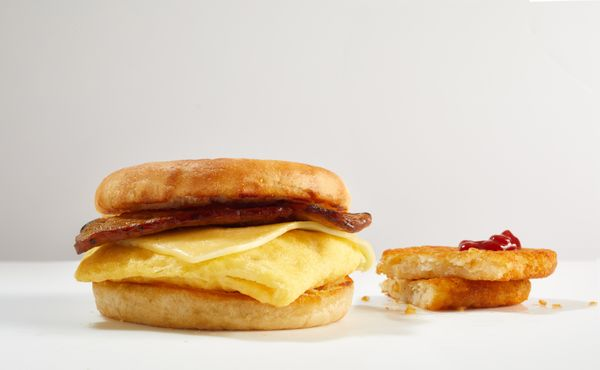

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Read the image using imread function
image = cv2.imread('/content/drive/MyDrive/CS608/final_photos/-1DM_eu7yFpuqRNA1doqDg.jpg')
cv2_imshow(image)

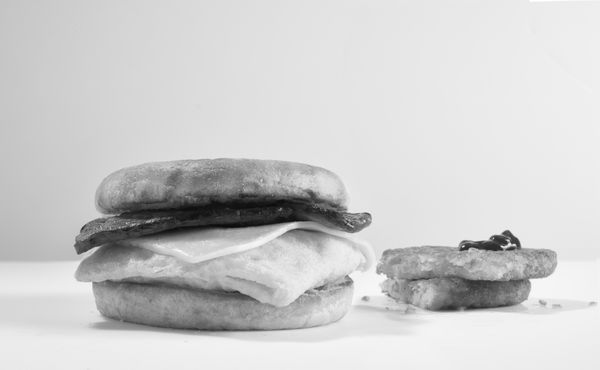

In [ ]:
# Read the image using imread function
image = cv2.imread('/content/drive/MyDrive/CS608/final_photos/-1DM_eu7yFpuqRNA1doqDg.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(image)

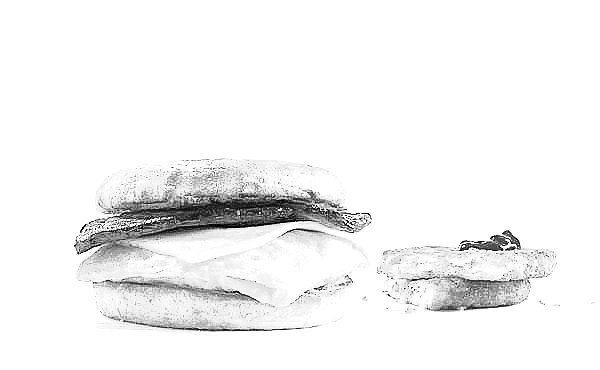

In [ ]:
# Read the image using imread function
image = cv2.imread('/content/drive/MyDrive/CS608/final_photos/-1DM_eu7yFpuqRNA1doqDg.jpg')
#image = image[:,:,0]
kernel_sharpening = np.array([[-1, -1, -1],
                             [-1, 10, -1],
                             [-1, -1, -1]])
sharpened = cv2.filter2D(image, -1, kernel_sharpening)
image = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)
cv2_imshow(image)

In [ ]:
import os
images = []
count = 0
file_names = os.listdir('/content/drive/MyDrive/CS608/final_photos')
for f in file_names:
  if '.jpg' in f:
    #print(f)
    image = cv2.imread('/content/drive/MyDrive/CS608/final_photos/'+f)
    down_width = 32
    down_height = 32
    down_points = (down_width, down_height)
    image = cv2.resize(image, down_points, interpolation= cv2.INTER_LINEAR)
    kernel_sharpening = np.array([[-1, -1, -1],
                             [-1, 10, -1],
                             [-1, -1, -1]])
    sharpened = cv2.filter2D(image, -1, kernel_sharpening)
    image = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)
    image = image / 255
    images.append(image)
images = np.array(images)
print(images)

[[[0.8        0.63921569 0.55294118 ... 0.21176471 0.         1.        ]
  [0.61568627 0.30980392 0.45882353 ... 0.         0.         1.        ]
  [0.78431373 0.71372549 0.43529412 ... 0.3372549  0.48627451 1.        ]
  ...
  [0.6745098  1.         1.         ... 0.         0.         0.        ]
  [1.         0.99215686 0.         ... 0.         0.         0.80392157]
  [1.         1.         1.         ... 0.         0.         0.66666667]]

 [[0.85882353 0.72941176 0.74901961 ... 0.14117647 0.01960784 0.01176471]
  [0.78039216 0.76862745 0.70980392 ... 0.         0.         0.05490196]
  [0.71764706 0.72941176 0.70588235 ... 1.         1.         1.        ]
  ...
  [0.44705882 0.63137255 1.         ... 0.0745098  0.         0.60392157]
  [0.56862745 0.56470588 0.97647059 ... 1.         0.         1.        ]
  [0.42352941 0.98039216 1.         ... 1.         0.9372549  0.04705882]]

 [[0.34117647 0.96862745 0.03137255 ... 0.         1.         1.        ]
  [0.27058824 0.454901

In [ ]:
len(images)

7907

In [ ]:
images = images.reshape(7907,-1)
images.shape
#np.array(images).shape

(7907, 1024)

In [ ]:
len(review['business_id'].unique())

7907

In [ ]:
ratings = []
for i in review.index:
  ratings.append((review.loc[i]['user_id'], review.loc[i]['business_id'], review.loc[i]['stars']))
ratings

[('smOvOajNG0lS4Pq7d8g4JQ', 'RZtGWDLCAtuipwaZ-UfjmQ', 4.0),
 ('IQsF3Rc6IgCzjVV9DE8KXg', 'eFvzHawVJofxSnD7TgbZtg', 5.0),
 ('vrKkXsozqqecF3CW4cGaVQ', 'rjuWz_AD3WfXJc03AhIO_w', 5.0),
 ('clWLI5OZP2ad25ugMVI8gg', 'x4XdNhp0Xn8lOivzc77J-g', 5.0),
 ('mNsVyC9tQVYtzLOCbh2Piw', 'MWmXGQ98KbRo3vsS5nZhMA', 5.0),
 ('Jha0USGDMefGFRLik_xFQg', 'bMratNjTG5ZFEA6hVyr-xQ', 5.0),
 ('aFa96pz67TwOFu4Weq5Agg', 'kq5Ghhh14r-eCxlVmlyd8w', 5.0),
 ('aWlojpSpzEICTza3RgGJgg', 'SIoCIxjn4jLt2O-4DajWJw', 4.0),
 ('EfG0nInFMbiO9Hy7A6B2cQ', 'fGYnHzFr1z2kv7bPRW6VMA', 3.0),
 ('FEI0XkOrUHufSW_rfOTPAA', 'Dv6RfXLYe1atjgz3Xf4GGw', 4.0),
 ('7Ie0VmQtnGYUVq2YW4dTVw', 'xruWHK8Z5N0JWyQubLHjgA', 5.0),
 ('EwoCJoV29tB-yAWJnZqJZA', 'G-zzByEfv2oqjcxYmPsjtA', 5.0),
 ('xXYNgEWnjaim2byFGLex-w', '7WZ5EGb-Xk_uxQTWc52P4w', 5.0),
 ('L-2Qdi16eMRbATGDP6ADHg', 'mQvRi0nm84Www71d4qOheQ', 5.0),
 ('hWDybu_KvYLSdEFzGrniTw', 'roc-xyyzN5b_nImb0NdRLQ', 4.0),
 ('ci7Q6NvXQ8UZrBHusVX18g', 'V6Om7YZhlRQRU7WfuxHq8Q', 4.0),
 ('0rZEWmL2rccd-N5VMzKLiQ', '7T1VAYHIS3c

In [ ]:
len(ratings)

374946

In [ ]:
item_ids = list(photo_dic.keys())
item_ids

['BELS5YkYjDFkpbM2FuDdaA',
 '3lW1gubDMpnEIlo45eUKhA',
 'jTFl9Cr7RqZqwjH-CI1ZPw',
 'tw_PmFjjCyg0t8Ek_kQz0Q',
 'jkGQQ4_LgJx3hwPtCFkzbQ',
 'WMkiheTT-8kRslImVLWMVw',
 'd_UJWp4IlGS4sgnjE60eBw',
 'ML8LRwVVebZLQhV30p2ktQ',
 'M6ZoEY54OKKPq9O9Boee7g',
 'BXVmIZlRe4n7v_WH8zzVjg',
 'a6nLdjFGoy3XmWhdtqBR3w',
 'NRb2aT7MKQXAG2HhoU4JKQ',
 'VkMokNW-HLye5jc8_1l_vA',
 'fmFiSeSGjaA8KI-xHB5Xxg',
 'AnxLo-wgSqSWePahtA3zEA',
 's-74t4aQKL2pWeQmIB-c1Q',
 'mF8czpMukj36ovHb3lGSeg',
 't6g6Lj8WzjIXXucCl9jdTQ',
 'jt1TfLJQN20aoVskD_8DuQ',
 'u3aN2A8Lo9odMCYjaphjLA',
 'vUrTGX_7HxqeoQ_6QCVz6g',
 'LImOqXSWUq-E_eNZhTUzmQ',
 'jNxvJeAUzzpC7zW3UN78HA',
 '5Tvy59J0Qi8ZFJu141t4Nw',
 'p1Y8bMd0ixx1dzj9oTjEOw',
 'K5WTakHfyimdWZ87QJJPUg',
 'fivoAD6x6jXJRiEZwhpcEQ',
 'pcy24IuPvHpj3bHvP6EitA',
 'xdferXKwbgXAxbtmAShhAQ',
 'jxEMFqwDJXjCxmcm5t5jVQ',
 'HTgKfmmlzgE43trhntv8-w',
 'Pb5agnsD9EdCl6yuZp2jJA',
 'tHlEq_yvHuutJ4UxxEeMEg',
 '3CFIqnjp0spaQzLfJfA-6Q',
 '6iGUJOIgUImvPaJwDf9pIA',
 'nIAbuktMEzVjT4P9pG89rQ',
 'LwX2vbzttWYAdoBoVtfvRg',
 

In [ ]:
print(len(ratings))
print(len(images))
print(len(item_ids))

374946
7907
7907


In [ ]:
images.shape #(2707)

(7907, 1024)

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/CS608/train_0.7.csv')
train_df

review_id                 user_id  \
0       S5-N1Zd7ch2Vow59QWwfnw  --2vR0DIsmQ6WfcSzKWigw   
1       NZmoh-ZvUCL9Pbn8nnTcvw  --2vR0DIsmQ6WfcSzKWigw   
2       QeQ_7auUrIA7ACm9Pvt3qQ  --2vR0DIsmQ6WfcSzKWigw   
3       fEGi0wNNo0GYV4fLpENXuA  --2vR0DIsmQ6WfcSzKWigw   
4       m3QNG3Ni7--EsiFv3IS3dg  --2vR0DIsmQ6WfcSzKWigw   
...                        ...                     ...   
177123  vDRjR34emmi-j_zyWHnIUw  zziJLt25YU6dp01sewR-IQ   
177124  4SjphMEO65OZmhAMHWNT_A  zziJLt25YU6dp01sewR-IQ   
177125  GwSfcXnufEsRG2Z8GGX7gQ  zziJLt25YU6dp01sewR-IQ   
177126  -uRNJrWttfxVxYudqyyMPA  zziJLt25YU6dp01sewR-IQ   
177127  zUMHYOwbFjZSoQdmtv21gw  zziJLt25YU6dp01sewR-IQ   

                   business_id  stars_x  useful  funny  cool  \
0       Mkr1Bm0SFo51L5-swly0bw  5.0      110     97     101    
1       tYJBFNJckCFiflhRLJnLjw  5.0      114     100    105    
2       Ib9HV7ekw459jM1Ksdiyiw  5.0      112     99     109    
3       vEyfMDd1u00EwCRGbpz36A  4.0      110     97     105    
4       -3e3CP3FFc-rvJj_-_airw  4.0      105     95     102    
...                        ...  ...      ...     ..     ...    
177123  FH8ZnbOiLpc5pcSsdqTfjg  4.0      1       0      1      
177124  PaOJy2n3oRBpIigV6TMxlg  2.0      1       0      0      
177125  fG6Wg3yrjY5Wm7UL00y3fw  3.0      0       0      0      
177126  W535RAHI-mlftEIZvKakHg  5.0      0       0      0      
177127  krCwF4raTYvBcCEwcbA88Q  3.0      0       0      0      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            text  \
0       Auf unserem Weg durch die Altstadt von Philadelphia sind wir auf einen kleinen Park mit einer ungewÃÂ¶hnlichen Statue gestoÃÂen. Es ist die sogenannte Signer Statue.\n\nDie Statue ist all denen gewidmet, die ihr Leben fÃÂ¼r die amerikanische Freiheit eingesetzt haben. In seiner Hand hÃÂ¤lt der Signer die GrÃÂ¼ndungsurkunde in den Himmel. Die Inspiration zu dieser Statue hat George Clymer gegeben, der Unterzeichner sowohl der UnabhÃÂ¤ngigkeitserklÃÂ¤rung und der Verfassung der Vereinigten Staaten war.\n\nWÃÂ¤hrend viele Statuen eher langweilig und staatsmÃÂ¤nnisch wirken, vermittelt dieses Kunstwerk eine gewisse Energie. Die Statue ist 9-1 / 2 Meter hoch, aus Bronze und steht auf einem

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/CS608/test_0.3.csv')
test_df

review_id                 user_id  \
0       -TDAxzdIkWxxqiVgW9Xf1A  --2vR0DIsmQ6WfcSzKWigw   
1       pVBwSCJDW59uf4OIz-dO7g  --2vR0DIsmQ6WfcSzKWigw   
2       c_DRiA8CPghSk8PR96K2Kg  --2vR0DIsmQ6WfcSzKWigw   
3       yUF1T08DTuAxt_J24pGr0g  --2vR0DIsmQ6WfcSzKWigw   
4       -wGzE2pTOZY5SGsEewobaw  --2vR0DIsmQ6WfcSzKWigw   
...                        ...                     ...   
411137  pLo-5eQJFu2q3H9FpUJCUw  znsZc4BhzCqGQyQg3X-j5Q   
411138  PPKXGf_2A-QEDG9ZQxumwQ  znsZc4BhzCqGQyQg3X-j5Q   
411139  qE0VurD2s_Bv2xOM74oHCA  znsZc4BhzCqGQyQg3X-j5Q   
411140  Dv7XUSqtK55GdeAYDls5FQ  znsZc4BhzCqGQyQg3X-j5Q   
411141  Rs_MxiJwlpPNY85UjZCkmQ  znsZc4BhzCqGQyQg3X-j5Q   

                   business_id  stars_x  useful  funny  cool  \
0       Jw-ENQw-OGGwpM3nA3ywqw  2.0      72      60     69     
1       iqJ3t9iq0fsWaYL93s8Vmw  5.0      68      57     64     
2       krCwF4raTYvBcCEwcbA88Q  4.0      67      56     59     
3       6yR6piTIuUG_9P_ctivxKw  5.0      76      67     73     
4       IBIp-yVFl2PxYS-rgc19Yg  5.0      107     93     104    
...                        ...  ...      ...     ..     ...    
411137  _RK29S6rmOUG8yahuHYpiQ  4.0      0       0      0      
411138  icOMQGI2G2wTzYoMB6084A  4.0      1       0      0      
411139  2EmAukTYm2mOBEIKEYBRNg  4.0      0       0      0      
411140  vUrTGX_7HxqeoQ_6QCVz6g  4.0      1       0      0      
411141  v45E6gg6MrAziTepkiWByA  4.0      0       0      0      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text  \
0       Mit unseren British Airways PrÃÂ¤mienpunkten konnten wir 3 NÃÂ¤chte im Best Western Plus Philadelphia Airport buchen. Das Hotel befindet sich in Chester und ist ca. 30 Minuten vom Philadelphia Zentrum entfernt.\n\nEs liegt in der NÃÂ¤he der Widener University in einer nicht so gepflegten Umgebung. Der Parkplatz liegt abseits vom Hotel und ist durch einen Durchgang zu erreichen. Im GebÃÂ¤udekomplex befindet sich noch ein 7 Eleven, wo man sich mit dem nÃÂ¶tigsten versorgen kann.\n\nDer Empfang war sehr freundlich und der Check Inn war problemlos. Das Hotel machte einen gepflegten Eindruck und unser Zimmer war groÃÂ und sauber. Das kostenfreie WLAN funktionierte flott.\n\nBei unse

In [ ]:
train_df = train_df[train_df['business_id'].isin(list(photo_dic.keys()))]

In [ ]:
test_df = test_df[test_df['business_id'].isin(list(photo_dic.keys()))]

In [ ]:
review.shape

(374946, 9)

In [ ]:
train_df.shape[0] + test_df.shape[0]

374946

In [ ]:
test_df.columns

Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful', 'funny',
       'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars_y', 'review_count',
       'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

In [ ]:
train_ratings = []
for i in train_df.index:
  train_ratings.append((train_df.loc[i]['user_id'], train_df.loc[i]['business_id'], train_df.loc[i]['stars_x']))
train_ratings

[('--2vR0DIsmQ6WfcSzKWigw', '-3e3CP3FFc-rvJj_-_airw', 4.0),
 ('--4AjktZiHowEIBCMd4CZA', 'wUnLSg_GKfEIQ5CQQ770_g', 4.0),
 ('--4AjktZiHowEIBCMd4CZA', 'a62d7e_xXeljJcOUHkJjkg', 5.0),
 ('--4AjktZiHowEIBCMd4CZA', 'vuE1iseFrgNPumUEfHIZZQ', 5.0),
 ('--4AjktZiHowEIBCMd4CZA', 'SO8kTCSO5dP5KyaX1JHDiA', 5.0),
 ('--4AjktZiHowEIBCMd4CZA', 'Yz0fJyBkUF8VZBvwFswkRQ', 5.0),
 ('--_r6E98SNIrGU7weyNxbw', 'lwCJ4KkAsRymBJJT3KCauQ', 1.0),
 ('--_r6E98SNIrGU7weyNxbw', 'RVzroffkQf6P8uv4qCBh8w', 2.0),
 ('--_r6E98SNIrGU7weyNxbw', 'VgFnAjjhK3AnV3u1-UVB2A', 1.0),
 ('--_r6E98SNIrGU7weyNxbw', 'iEipb1sh0CiHScEgpPNDow', 2.0),
 ('--_r6E98SNIrGU7weyNxbw', '3vJOrpZxF2ctaM4hhpuu9A', 4.0),
 ('--_r6E98SNIrGU7weyNxbw', '5XXFFeHDa-lb-OcXGDKXpg', 5.0),
 ('--_r6E98SNIrGU7weyNxbw', 'huEf-4ICYGjrNAsOslinWQ', 3.0),
 ('--_r6E98SNIrGU7weyNxbw', 'Y0I8efE0ryP1--p4NK_rbA', 5.0),
 ('--_r6E98SNIrGU7weyNxbw', '9pc7HKeHRkBIcrjqcP_OeQ', 5.0),
 ('--_r6E98SNIrGU7weyNxbw', 'WmbwdluLzN8qXfYjYKPkqA', 4.0),
 ('--ccVMj2PN6Z9qtdOdlung', '9ggTidLF9LP

In [ ]:
test_ratings = []
for i in test_df.index:
  test_ratings.append((test_df.loc[i]['user_id'], test_df.loc[i]['business_id'], test_df.loc[i]['stars_x']))
test_ratings

[('--4AjktZiHowEIBCMd4CZA', 'wm5mQ4cSpvko9WlCq07RFw', 5.0),
 ('--4AjktZiHowEIBCMd4CZA', 'LNHq9WxfhN2UBNOR2tnRQQ', 5.0),
 ('--4AjktZiHowEIBCMd4CZA', '7J_7uvHEV94C4TocWPPxfQ', 4.0),
 ('--4AjktZiHowEIBCMd4CZA', 'EtKSTHV5Qx_Q7Aur9o4kQQ', 4.0),
 ('--4AjktZiHowEIBCMd4CZA', 'OLkS4jfozQpUIUq0K6t_IQ', 3.0),
 ('--4AjktZiHowEIBCMd4CZA', 'hCMqbFJyLczPk_qU3Ym2Cw', 5.0),
 ('--4AjktZiHowEIBCMd4CZA', 'tYn8hGpZiRgJ8cP2FcI_YQ', 4.0),
 ('--_r6E98SNIrGU7weyNxbw', 'ctC-HU2Jbv04I42ykXFjLA', 5.0),
 ('--_r6E98SNIrGU7weyNxbw', '36_FvBjdMXC949XVYDUb6A', 5.0),
 ('--_r6E98SNIrGU7weyNxbw', 'nJ4RKwRgkGiD4fE0QAg5mg', 4.0),
 ('--_r6E98SNIrGU7weyNxbw', 'wnWdf_IeR8wCnesA1p-3nw', 2.0),
 ('--_r6E98SNIrGU7weyNxbw', 'wnWdf_IeR8wCnesA1p-3nw', 2.0),
 ('--_r6E98SNIrGU7weyNxbw', 'dq21CR1WYujxYksXjcnKpg', 5.0),
 ('--_r6E98SNIrGU7weyNxbw', '1Efjww8n7WtKtKTgDqjgdA', 1.0),
 ('--_r6E98SNIrGU7weyNxbw', 'JjYmXia9-Dy0tGqI088Hfg', 5.0),
 ('--_r6E98SNIrGU7weyNxbw', '1Fs3_bjPQwvSXZHGGlFE-A', 4.0),
 ('--_r6E98SNIrGU7weyNxbw', 'nb4q4rKYdtg

In [ ]:
print(len(images))

7907


In [ ]:
print(len(item_ids))

7907


# Model Comparison

In [ ]:
# no image processing
vbpr_130 = VBPR(k=130, k2=130, n_epochs=30, batch_size=100, learning_rate=0.001,
            lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, verbose=VERBOSE, seed=SEED, name = f'VBPR(K={130})')

item_image_modality = ImageModality(features=images, ids=item_ids, normalized=False)

base_method = BaseMethod.from_splits(
              train_data = train_ratings, 
              test_data = test_ratings, 
              rating_threshold=4.0,
              exclude_unknowns=False,
              item_image=item_image_modality,
              verbose=VERBOSE,
               seed=SEED,
              )

eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]



cornac.Experiment(eval_method=base_method, models=[vbpr_130], metrics=eval_metrics).run()

rating_threshold = 4.0
exclude_unknowns = False


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 2274 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 20968
Number of items = 7323
Number of ratings = 110858
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 8498 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Test data:
Number of users = 25821
Number of items = 7804
Number of ratings = 253316
Number of unknown users = 5738
Number of unknown items = 584
---
Total users = 26706
Total items = 7907

[VBPR(K=130)] Training started!


Epoch 1/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Optimization finished!

[VBPR(K=130)] Evaluation started!


Rating:   0%|          | 0/253316 [00:00<?, ?it/s]

Ranking:   0%|          | 0/25821 [00:00<?, ?it/s]


TEST:
...
            |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
----------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
VBPR(K=130) | 2.4234 | 0.6538 | 0.0160 | 0.0162 | 0.0640 |  0.0244 |  0.0287 |  0.0319 |       0.0145 |    0.0245 | 3521.0986 | 138.9993



In [ ]:
from cornac.eval_methods import BaseMethod

In [ ]:
vbpr_130 = VBPR(k=130, k2=130, n_epochs=50, batch_size=100, learning_rate=0.001,
            lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, verbose=VERBOSE, seed=SEED, name = f'VBPR(K={130})')

item_image_modality = ImageModality(features=images, ids=item_ids, normalized=False)

base_method = BaseMethod.from_splits(
              train_data = train_ratings, 
              test_data = test_ratings, 
              rating_threshold=4.0,
              exclude_unknowns=False,
              item_image=item_image_modality,
              verbose=VERBOSE,
               seed=SEED,
              )

eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]



cornac.Experiment(eval_method=base_method, models=[vbpr_130], metrics=eval_metrics).run()

rating_threshold = 4.0
exclude_unknowns = False


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 2274 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 20968
Number of items = 7323
Number of ratings = 110858
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 8498 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Test data:
Number of users = 25821
Number of items = 7804
Number of ratings = 253316
Number of unknown users = 5738
Number of unknown items = 584
---
Total users = 26706
Total items = 7907

[VBPR(K=130)] Training started!


Epoch 1/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Optimization finished!

[VBPR(K=130)] Evaluation started!


Rating:   0%|          | 0/253316 [00:00<?, ?it/s]

Ranking:   0%|          | 0/25821 [00:00<?, ?it/s]


TEST:
...
            |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
----------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
VBPR(K=130) | 2.5401 | 0.6569 | 0.0180 | 0.0176 | 0.0704 |  0.0274 |  0.0315 |  0.0348 |       0.0164 |    0.0271 | 5560.3622 | 146.6048



In [ ]:
vbpr_150 = VBPR(k=150, k2=150, n_epochs=50, batch_size=100, learning_rate=0.001,
            lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, verbose=VERBOSE, seed=SEED, name = f'VBPR(K={150})')

item_image_modality = ImageModality(features=images, ids=item_ids, normalized=False)

base_method = BaseMethod.from_splits(
              train_data = train_ratings, 
              test_data = test_ratings, 
              rating_threshold=4.0,
              exclude_unknowns=False,
              item_image=item_image_modality,
              verbose=VERBOSE,
               seed=SEED,
              )

eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]



cornac.Experiment(eval_method=base_method, models=[vbpr_150], metrics=eval_metrics).run()

rating_threshold = 4.0
exclude_unknowns = False


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 2274 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 20968
Number of items = 7323
Number of ratings = 110858
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 8498 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Test data:
Number of users = 25821
Number of items = 7804
Number of ratings = 253316
Number of unknown users = 5738
Number of unknown items = 584
---
Total users = 26706
Total items = 7907

[VBPR(K=150)] Training started!


Epoch 1/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1109 [00:00<?, ?it/s]

Optimization finished!

[VBPR(K=150)] Evaluation started!


Rating:   0%|          | 0/253316 [00:00<?, ?it/s]

Ranking:   0%|          | 0/25821 [00:00<?, ?it/s]


TEST:
...
            |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
----------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
VBPR(K=150) | 2.5031 | 0.6580 | 0.0182 | 0.0175 | 0.0698 |  0.0274 |  0.0314 |  0.0347 |       0.0166 |    0.0277 | 6403.2406 | 143.3272



In [ ]:
vbpr_150 = VBPR(k=150, k2=150, n_epochs=50, batch_size=16, learning_rate=0.001,
            lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, verbose=VERBOSE, seed=SEED, name = f'VBPR(K={150})')

item_image_modality = ImageModality(features=images, ids=item_ids, normalized=False)

base_method = BaseMethod.from_splits(
              train_data = train_ratings, 
              test_data = test_ratings, 
              rating_threshold=4.0,
              exclude_unknowns=False,
              item_image=item_image_modality,
              verbose=VERBOSE,
               seed=SEED,
              )

eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]



cornac.Experiment(eval_method=base_method, models=[vbpr_150], metrics=eval_metrics).run()

rating_threshold = 4.0
exclude_unknowns = False


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 2274 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 20968
Number of items = 7323
Number of ratings = 110858
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 8498 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Test data:
Number of users = 25821
Number of items = 7804
Number of ratings = 253316
Number of unknown users = 5738
Number of unknown items = 584
---
Total users = 26706
Total items = 7907

[VBPR(K=150)] Training started!


Epoch 1/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/6929 [00:00<?, ?it/s]

Optimization finished!

[VBPR(K=150)] Evaluation started!


Rating:   0%|          | 0/253316 [00:00<?, ?it/s]

Ranking:   0%|          | 0/25821 [00:00<?, ?it/s]


TEST:
...
            |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
----------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
VBPR(K=150) | 2.3643 | 0.7126 | 0.0183 | 0.0186 | 0.0715 |  0.0270 |  0.0323 |  0.0367 |       0.0170 |    0.0265 | 2702.4412 | 105.1781



In [ ]:
import pickle
pickle.dump(vbpr_150, open('/content/drive/MyDrive/CS608/vbpr150_0.017', 'wb'))

In [ ]:
loaded_model = pickle.load(open('/content/drive/MyDrive/CS608/vbpr150_0.017', 'rb'))

In [ ]:
def output_top(model, uid, top_k = 10):
  user_id = list(model.train_set.user_ids)
  item_id = list(model.train_set.item_ids)
 
  print('Start prediction...') 
  item_map = {v:k for k, v in model.train_set.iid_map.items()}
 
  uidx = user_id.index(uid)
  iidx = model.rank(user_idx = uidx)[0][:top_k]
 
  result = [item_map[item_idx] for item_idx in iidx]
 
  return result
#'wbYGNhp2A3rGmQUzNwng1A', 'vCHNWdW-ys-nWUx3Cpvk8Q'
# 'tCXElwhzekJEH6QJe3xs7Q', 'MTSW4McQd7CbVtyjqoe9mw'
# 'Y1nvrBvXHECKgL2_LyjjmQ', 'YgMZm_alGFUeQO4hz9X9VA'
img_top_10_rec = output_top(loaded_model, uid = 'Y1nvrBvXHECKgL2_LyjjmQ')
img_top_10_rec

Start prediction...


['2pDXWt8KnncH7FEHL25NvA',
 'dERS4qwl9v-Gwft-Ug8APA',
 'Td1xw31b7pGiShjpzc5hJw',
 '3FqvW2DgDNdVy3kAbm8kwg',
 'jHABRqH3hcPKvaOMt75Rfg',
 '_X6eMQoZX9GdSgSwOapwMA',
 'V9pSmHb0c-9SSqx5GJbYPg',
 'H3EK1Q8tqRGqPBps05Uahw',
 '8kUh6TROemLfbVR_ewVVLg',
 '9gObo5ltOMo6UgsaXaHPWA']

In [ ]:
business[business.business_id.isin(img_top_10_rec)][['name', 'city', 'categories']]

name          city  \
1379    West Ave Grille Jenkintown Restaurant and Food Truck   Jenkintown     
9336    R2L                                                    Philadelphia   
31175   IL Granaio                                             Glen Mills     
53980   Tashan                                                 Philadelphia   
54968   Nam Phuong                                             Philadelphia   
78726   Altomonte's Italian Market & Delicatessen              Warminster     
86804   Vereinigung Erzgebirge                                 Warminster     
111747  OOKA Sushi, Bar, Hibachi Steak house                   Doylestown     
133936  Buttonwood Grill                                       New Hope       
148364  Walgreens                                              Philadelphia   

                                                                                                                                                       categories  
1379    Restaurants, Sandwiches, Breakfast & Brunch, Caterers, American (New), Comfort Food, Food Trucks, Event Planning & Services, American (Traditional), Food  
9336    American (New), Lounges, Nightlife, Cocktail Bars, Bars, Restaurants                                                                                       
31175   Italian, Restaurants, Bars, Nightlife                                                                                                                      
53980   Asian Fusion, Indian, Modern European, Restaurants, Vegetarian                                                                                             
54968   Restaurants, Seafood, Vietnamese                                                                                                                           
78726   Food, Caterers, Restaurants, Butcher, Event Planning & Services, Grocery, Delis                                                                            
86804   Event Planning & Services, Caterers, Nightlife, Restaurants, Soccer, German, Active Life                                                                   
111747  Sushi Bars, Restaurants, Japanese                                                                                                                          
133936  Burgers, Restaurants, Breakfast & Brunch, Gastropubs, American (New)                                                                                       
148364  Shopping, Drugstores, Convenience Stores, Food, Cosmetics & Beauty Supply, Beauty & Spas, Photography Stores & Services

In [ ]:
photo_dic['YgMZm_alGFUeQO4hz9X9VA']

'nyyBuYwdY1IEtCb3s-szZQ'

In [ ]:
business[business['business_id'] == 'YgMZm_alGFUeQO4hz9X9VA'][['business_id', 'name', 'city', 'categories']]

business_id                 name      city  \
2846  YgMZm_alGFUeQO4hz9X9VA  Earl's New American  New Hope   

                                                                           categories  
2846  Nightlife, American (New), Bars, Seafood, Restaurants, Wine Bars, Cocktail Bars

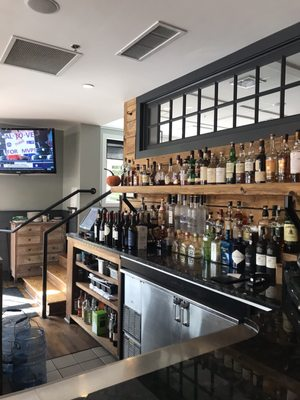

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Read the image using imread function
image = cv2.imread('/content/drive/MyDrive/CS608/final_photos/nyyBuYwdY1IEtCb3s-szZQ.jpg')
cv2_imshow(image)

In [ ]:
import pickle
pickle.dump(vbpr_150, open('VPBR_150', 'wb'))

In [ ]:
vbpr_90 = VBPR(k=90, k2=90, n_epochs=30, batch_size=100, learning_rate=0.001,
            lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, verbose=VERBOSE, seed=SEED, name = f'VBPR(K={90})')

item_image_modality = ImageModality(features=images, ids=item_ids, normalized=False)

base_method = BaseMethod.from_splits(
              train_data = train_ratings, 
              test_data = test_ratings, 
              rating_threshold=4.0,
              exclude_unknowns=False,
              item_image=item_image_modality,
              verbose=VERBOSE,
               seed=SEED,
              )

eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]



cornac.Experiment(eval_method=base_method, models=[vbpr_90], metrics=eval_metrics).run()

rating_threshold = 4.0
exclude_unknowns = False


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 2274 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 20968
Number of items = 7323
Number of ratings = 110858
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 8498 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Test data:
Number of users = 25821
Number of items = 7804
Number of ratings = 253316
Number of unknown users = 5738
Number of unknown items = 584
---
Total users = 26706
Total items = 7907

[VBPR(K=90)] Training started!


Epoch 1/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/1109 [00:00<?, ?it/s]

Optimization finished!

[VBPR(K=90)] Evaluation started!


Rating:   0%|          | 0/253316 [00:00<?, ?it/s]

Ranking:   0%|          | 0/25821 [00:00<?, ?it/s]


TEST:
...
           |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
VBPR(K=90) | 2.4501 | 0.6515 | 0.0173 | 0.0176 | 0.0711 |  0.0271 |  0.0314 |  0.0348 |       0.0158 |    0.0264 | 2389.2362 | 141.0783



In [ ]:
VMF_150 = VMF(k=150,
              d=150,
            n_epochs=10,
            batch_size=100,
            learning_rate=0.001,
            gamma=0.9,
            lambda_u=0.001,
            lambda_v=0.001,
            lambda_p=1.0,
            lambda_e=10.0,
            use_gpu=True,
            verbose=True, name = f'VMF(K={150})')

item_image_modality = ImageModality(features=images, ids=item_ids, normalized=False)

base_method = BaseMethod.from_splits(
              train_data = train_ratings, 
              test_data = test_ratings, 
              rating_threshold=4.0,
              exclude_unknowns=False,
              item_image=item_image_modality,
              verbose=VERBOSE,
               seed=SEED,
              )

eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]



cornac.Experiment(eval_method=base_method, models=[VMF_150], metrics=eval_metrics).run()

rating_threshold = 4.0
exclude_unknowns = False


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 2274 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 20968
Number of items = 7323
Number of ratings = 110858
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 8498 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Test data:
Number of users = 25821
Number of items = 7804
Number of ratings = 253316
Number of unknown users = 5738
Number of unknown items = 584
---
Total users = 26706
Total items = 7907

[VMF(K=150)] Training started!
Learning...


Epoch 1/10:   0%|          | 0/1109 [00:00<?, ?it/s]

7925.39321364208


Epoch 2/10:   0%|          | 0/1109 [00:00<?, ?it/s]

7041.892368907355


Epoch 3/10:   0%|          | 0/1109 [00:00<?, ?it/s]

6516.3034454613435


Epoch 4/10:   0%|          | 0/1109 [00:00<?, ?it/s]

6043.756770027504


Epoch 5/10:   0%|          | 0/1109 [00:00<?, ?it/s]

5520.412240349077


Epoch 6/10:   0%|          | 0/1109 [00:00<?, ?it/s]

4966.093355103134


Epoch 7/10:   0%|          | 0/1109 [00:00<?, ?it/s]

4399.375927795742


Epoch 8/10:   0%|          | 0/1109 [00:00<?, ?it/s]

3860.875734727393


Epoch 9/10:   0%|          | 0/1109 [00:00<?, ?it/s]

3364.0603643817913


Epoch 10/10:   0%|          | 0/1109 [00:00<?, ?it/s]

2933.9717041593885
Learning completed

[VMF(K=150)] Evaluation started!


Rating:   0%|          | 0/253316 [00:00<?, ?it/s]

Ranking:   0%|          | 0/25821 [00:00<?, ?it/s]


TEST:
...
           |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
VMF(K=150) | 1.3321 | 0.5330 | 0.0145 | 0.0160 | 0.0629 |  0.0234 |  0.0265 |  0.0294 |       0.0141 |    0.0213 |   89.4469 | 124.2913



In [ ]:
VMF_200 = VMF(k=200,
              d=200,
            n_epochs=10,
            batch_size=100,
            learning_rate=0.001,
            gamma=0.9,
            lambda_u=0.001,
            lambda_v=0.001,
            lambda_p=1.0,
            lambda_e=10.0,
            use_gpu=True,
            verbose=True, name = f'VMF(K={200})')

item_image_modality = ImageModality(features=images, ids=item_ids, normalized=False)

base_method = BaseMethod.from_splits(
              train_data = train_ratings, 
              test_data = test_ratings, 
              rating_threshold=4.0,
              exclude_unknowns=False,
              item_image=item_image_modality,
              verbose=VERBOSE,
               seed=SEED,
              )

eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]



cornac.Experiment(eval_method=base_method, models=[VMF_200], metrics=eval_metrics).run()

rating_threshold = 4.0
exclude_unknowns = False


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 2274 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 20968
Number of items = 7323
Number of ratings = 110858
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 8498 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Test data:
Number of users = 25821
Number of items = 7804
Number of ratings = 253316
Number of unknown users = 5738
Number of unknown items = 584
---
Total users = 26706
Total items = 7907

[VMF(K=200)] Training started!
Learning...


Epoch 1/10:   0%|          | 0/1109 [00:00<?, ?it/s]

8049.171787893609


Epoch 2/10:   0%|          | 0/1109 [00:00<?, ?it/s]

7181.511585750839


Epoch 3/10:   0%|          | 0/1109 [00:00<?, ?it/s]

6575.792703921685


Epoch 4/10:   0%|          | 0/1109 [00:00<?, ?it/s]

6005.789328415079


Epoch 5/10:   0%|          | 0/1109 [00:00<?, ?it/s]

5370.0705046428175


Epoch 6/10:   0%|          | 0/1109 [00:00<?, ?it/s]

4716.999533482658


Epoch 7/10:   0%|          | 0/1109 [00:00<?, ?it/s]

4074.811645292057


Epoch 8/10:   0%|          | 0/1109 [00:00<?, ?it/s]

3498.860508177514


Epoch 9/10:   0%|          | 0/1109 [00:00<?, ?it/s]

2994.991792126713


Epoch 10/10:   0%|          | 0/1109 [00:00<?, ?it/s]

2579.4810870671595
Learning completed

[VMF(K=200)] Evaluation started!


Rating:   0%|          | 0/253316 [00:00<?, ?it/s]

Ranking:   0%|          | 0/25821 [00:00<?, ?it/s]


TEST:
...
           |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
VMF(K=200) | 1.3320 | 0.5362 | 0.0148 | 0.0160 | 0.0632 |  0.0238 |  0.0264 |  0.0292 |       0.0142 |    0.0217 |  111.2734 | 127.0168



In [ ]:
VMF_160 = VMF(k=160,
              d=160,
            n_epochs=10,
            batch_size=100,
            learning_rate=0.001,
            gamma=0.9,
            lambda_u=0.001,
            lambda_v=0.001,
            lambda_p=1.0,
            lambda_e=10.0,
            use_gpu=True,
            verbose=True, name = f'VMF(K={160})')

item_image_modality = ImageModality(features=images, ids=item_ids, normalized=False)

base_method = BaseMethod.from_splits(
              train_data = train_ratings, 
              test_data = test_ratings, 
              rating_threshold=4.0,
              exclude_unknowns=False,
              item_image=item_image_modality,
              verbose=VERBOSE,
               seed=SEED,
              )

eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]



cornac.Experiment(eval_method=base_method, models=[VMF_160], metrics=eval_metrics).run()

rating_threshold = 4.0
exclude_unknowns = False


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 2274 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 20968
Number of items = 7323
Number of ratings = 110858
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9


/usr/local/lib/python3.7/dist-packages/cornac/data/dataset.py:361: UserWarning: 8498 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Test data:
Number of users = 25821
Number of items = 7804
Number of ratings = 253316
Number of unknown users = 5738
Number of unknown items = 584
---
Total users = 26706
Total items = 7907

[VMF(K=160)] Training started!
Learning...


Epoch 1/10:   0%|          | 0/1109 [00:00<?, ?it/s]

7941.022003179544


Epoch 2/10:   0%|          | 0/1109 [00:00<?, ?it/s]

7056.895507460298


Epoch 3/10:   0%|          | 0/1109 [00:00<?, ?it/s]

6513.892461267722


Epoch 4/10:   0%|          | 0/1109 [00:00<?, ?it/s]

6019.978790716033


Epoch 5/10:   0%|          | 0/1109 [00:00<?, ?it/s]

5471.319066418388


Epoch 6/10:   0%|          | 0/1109 [00:00<?, ?it/s]

4896.461007802023


Epoch 7/10:   0%|          | 0/1109 [00:00<?, ?it/s]

4319.304723623739


Epoch 8/10:   0%|          | 0/1109 [00:00<?, ?it/s]

3775.3247102444043


Epoch 9/10:   0%|          | 0/1109 [00:00<?, ?it/s]

3280.93182279882


Epoch 10/10:   0%|          | 0/1109 [00:00<?, ?it/s]

2853.4902514006576
Learning completed

[VMF(K=160)] Evaluation started!


Rating:   0%|          | 0/253316 [00:00<?, ?it/s]

Ranking:   0%|          | 0/25821 [00:00<?, ?it/s]


TEST:
...
           |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
---------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
VMF(K=160) | 1.3281 | 0.5358 | 0.0145 | 0.0158 | 0.0625 |  0.0233 |  0.0260 |  0.0289 |       0.0140 |    0.0215 |   93.7400 | 124.3466



In [ ]:
pickle.dump(VMF_150, open('/content/drive/MyDrive/CS608/VMF_150', 'wb'))